In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random

from torchvision import datasets, transforms
from copy import deepcopy

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_mnist(is_train=True, flatten=True):

    dataset = datasets.MNIST(
        '../data', train=is_train, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
        ]),
    )

    x = dataset.data.float() / 255. # Scaling: MNIST 데이터셋은 기존에 각 Element 값이 0~255라 /255.가 Min-Max Scaling 역할을 수행함
    y = dataset.targets

    if flatten:
        x = x.view(x.size(0), -1) # (28,28) -> (28*28,) 형태로 Flatten해서 Neural Network Input으로 넣어주기 위함

    return x, y

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [4]:
# MNIST 데이터 불러오기 및 Train/Validation/Test Set 분할

train_x, train_y = load_mnist(flatten=True)
test_x, test_y = load_mnist(is_train=False, flatten=True)
test_x, test_y = test_x, test_y

train_cnt = int(train_x.size(0) * 0.8)
valid_cnt = train_x.size(0) - train_cnt

# Shuffle dataset to split into train/valid set.
indices = torch.randperm(train_x.size(0))
train_x, valid_x = torch.index_select(
    train_x,
    dim=0,
    index=indices
).split([train_cnt, valid_cnt], dim=0)
train_x, valid_x = train_x, valid_x

train_y, valid_y = torch.index_select(
    train_y,
    dim=0,
    index=indices
).split([train_cnt, valid_cnt], dim=0)
train_y, valid_y = train_y, valid_y

print("Train:", train_x.shape, train_y.shape)
print("Valid:", valid_x.shape, valid_y.shape)
print("Test:", test_x.shape, test_y.shape)

Train: torch.Size([48000, 784]) torch.Size([48000])
Valid: torch.Size([12000, 784]) torch.Size([12000])
Test: torch.Size([10000, 784]) torch.Size([10000])


In [5]:
# MNIST Data Instance 시각화 함수 정의 
def show_image(x):
    if x.dim() == 1: # 만약 x의 dim이 1이라면 (x를 flatten() 해서 1차원 벡터 형태로 만든 경우)
        x = x.cpu()
        x = x.view(int(x.size(0) ** .5), -1) # dim = 2로 변환
    
    plt.figure(figsize=(1,1))
    plt.imshow(x, cmap='gray') # Grayscale 이미지
    plt.show()

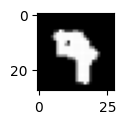

In [6]:
show_image(train_x[0].flatten())

## AutoEncoder 구현

In [7]:
class Shallow_AE(nn.Module):
    
    def __init__(self, btl_size=2):   # 입력 인자로 bottle neck size를 받음
        self.btl_size = btl_size
        
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 100),  # MNIST input이 28*28 형태라서 28*28을 flatten한 784를 입력으로 받음  즉, x는 784차원에 해당
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Linear(100, btl_size),    # 주의! Encoder와 Decoder의 마지막 Layer는 그냥 Linear Layer임
                                        # 마지막에 Activaiton Function(ReLU 등)이나 BatchNormalization이 없음!
        )
        self.decoder = nn.Sequential(
            nn.Linear(btl_size, 100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Linear(100, 28 * 28),
        )        
        # 현재 이 코드에서는 encoder와 decoder를 대칭되게 짰는데, 꼭 대칭일 필요는 없음.
        # 예를 들어서 encoder의 레이어를 더 deep하게 만들고, decoder를 더 얕게 만들수도 있음
        
    def forward(self, x):
        z = self.encoder(x)  # |x| = (batch_size, 784), |z| = (batch_size, btl_size)
        y = self.decoder(z)  # |y| = |x|
        
        return y

In [8]:
class Deep_AE(nn.Module):
    
    def __init__(self, btl_size=2):   
        self.btl_size = btl_size
        
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 300),  
            nn.ReLU(),
            nn.BatchNorm1d(300),
            nn.Linear(300, 200),
            nn.ReLU(),
            nn.BatchNorm1d(200),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.BatchNorm1d(50),
            nn.Linear(50, 10),
            nn.ReLU(),
            nn.BatchNorm1d(10),
            nn.Linear(10, btl_size),   
        )
        self.decoder = nn.Sequential(
            nn.Linear(btl_size, 10),
            nn.ReLU(),
            nn.BatchNorm1d(10),
            nn.Linear(10, 50),
            nn.ReLU(),
            nn.BatchNorm1d(50),
            nn.Linear(50, 100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Linear(100, 200),
            nn.ReLU(),
            nn.BatchNorm1d(200),
            nn.Linear(200, 300),
            nn.ReLU(),
            nn.BatchNorm1d(300),
            nn.Linear(300, 28 * 28),
        )
        
    def forward(self, x):
        z = self.encoder(x) 
        y = self.decoder(z) 
        
        return y

In [9]:
# Model 학습에 사용할 Trainer 클래스 정의
class Trainer():

    def __init__(self, model, optimizer, crit, batch_size = 128, n_epochs = 50, verbose = 1):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.crit = crit
        self.batch_size = batch_size
        self.n_epochs = n_epochs 
        self.verbose = verbose

        super().__init__()

    def _train(self, x, y): # 사용자 정의 함수 앞에 _를 붙인 이유: Trainer() 객체를 생성한 후에 이 함수에 접근하는 것을 방지하기 위함. (객체._train() 이라고 코드 입력 시 접근 가능하긴 하지만, 일차적으로 객체. 했을 떄 GUI 상에 표시되지 않음)
        self.model.train() # 모델 Train() 모드 시작

        # Data 셔플해주기
        # 본 튜토리얼에서는 AutoEncoder를 사용하기 때문에 y(Class Label)은 사용되지 않지만 튜토리얼이라는 측면에서 함께 작성함
        indices = torch.randperm(x.size(0), device=x.device)
        x = torch.index_select(x, dim=0, index=indices).split(self.batch_size, dim=0)  # Shuffle 후, batch_size로 기존 x를 나눠줍니다. 즉, x = [batch_1, batch_2, batch_3, ...]와 같이 리스트 안에 batch_x가 Element로 들어가게 됩니다.
        y = torch.index_select(y, dim=0, index=indices).split(self.batch_size, dim=0)

        total_loss = 0

        for i, (x_i, y_i) in enumerate(zip(x, y)):
            y_hat_i = self.model(x_i)
            loss_i = self.crit(y_hat_i, y_i.squeeze())

            # 모델의 Gradient를 초기화
            self.optimizer.zero_grad()
            loss_i.backward()  # Gradient 계산

            self.optimizer.step() # .backward()를 통해 산출된 Gradient를 이용해 파라미터 업데이트

            if self.verbose >= 2: # Iteration 별 Train Loss를 확인하고자 한다면 verbose에 2 이상의 값을 입력 (훈련 과정을 조금 더 자세히 보고 싶으신 분들을 위해 추가하긴 했지만, Epoch마다 Loss 값을 출력하게 만들어놨기 때문에 verbose를 사용하는 것은 개인적으로 비추천합니다. 정말 Verbose(수다스러운)해집니다.)
                print("Train Iteration(%d/%d): loss=%.4e" % (i + 1, len(x), float(loss_i)))

            # OOM 문제를 방지하기 위한 노력의 일환으로 loss를 float() 데이터 타입으로 변경. float()을 하지 않을 경우 loss에 gradient 정보가 남아 있어서 현재 단계에서 필요하지 않은 메모리를 사용하게 됩니다. (동일한 목적으로 종종 loss.detach()를 사용하기도 합니다.)
            total_loss += float(loss_i)

        return total_loss / len(x)

    def _validate(self, x, y):
        self.model.eval() # 모델 Evaluatioin 모드 시작

        # Validation Phase와 Test Phase에서는 Gradient Descent를 통한 파라미터 업데이트가 이루어지지 않기 때문에 gradient를 사용하지 않겠다는 의미로 with torch.no_grad()를 사용합니다.
        with torch.no_grad():
            indices = torch.randperm(x.size(0), device=x.device)
            x = torch.index_select(x, dim=0, index=indices).split(self.batch_size, dim=0)
            y = torch.index_select(y, dim=0, index=indices).split(self.batch_size, dim=0)

            total_loss = 0

            for i, (x_i, y_i) in enumerate(zip(x, y)):
                y_hat_i = self.model(x_i)
                loss_i = self.crit(y_hat_i, y_i.squeeze())

                if self.verbose >= 2:
                    print("Valid Iteration(%d/%d): loss=%.4e" % (i + 1, len(x), float(loss_i)))

                total_loss += float(loss_i)

            return total_loss / len(x)

    def train(self, train_data, valid_data):
        lowest_loss = np.inf   # 초기 최저 Loss 값을 무한대로 설정 -> 추후 모델이 Train을 진행하면서 Loss 값이 낮아지게 되면서 lowset_loss 값이 갱신됩니다.
        best_model = None  # best_model이 아직은 train을 시작하기 전이므로 None으로 선언합니다.

        for epoch_index in range(self.n_epochs): # 각 에포크 별 학습 시작
            train_loss = self._train(train_data[0], train_data[1])
            valid_loss = self._validate(valid_data[0], valid_data[1])

            # Best Model의 파라미터를 저장하기 위해 deepcopy() 사용 
            # 참고: 본 튜토리얼에서는 Early Stopping은 사용하지 않음. 대신 n_epochs 동안 Training을 진행하면서 Valid_Loss가 가장 낮았던 model을 최종 model로 사용함
            if valid_loss <= lowest_loss:
                lowest_loss = valid_loss
                best_model = deepcopy(self.model.state_dict())

            if epoch_index % 20 == 0: # Epoch 5번마다 Loss 출력

                print("Epoch(%d/%d): train_loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e" % (
                    epoch_index + 1,
                    self.n_epochs,
                    train_loss,
                    valid_loss,
                    lowest_loss,
                ))

        # Restore to best model.
        self.model.load_state_dict(best_model)

## Shallow AutoEncoder, Deep AutoEncoder 이미지 복원 결과 비교

In [28]:
# Shallow AutoEncoder Train 
shallow_model = Shallow_AE(btl_size=5)
shallow_model = shallow_model
optimizer = optim.Adam(shallow_model.parameters())
crit = nn.MSELoss() 

trainer = Trainer(shallow_model, optimizer, crit, batch_size = 512, n_epochs = 100, verbose = 1)
trainer.train((train_x.to(device), train_x.to(device)), (valid_x.to(device),valid_x.to(device)))

Epoch(1/100): train_loss=1.1112e-01  valid_loss=5.5758e-02  lowest_loss=5.5758e-02
Epoch(21/100): train_loss=3.3665e-02  valid_loss=3.3424e-02  lowest_loss=3.3424e-02
Epoch(41/100): train_loss=3.1457e-02  valid_loss=3.1439e-02  lowest_loss=3.1438e-02
Epoch(61/100): train_loss=3.0512e-02  valid_loss=3.0580e-02  lowest_loss=3.0580e-02
Epoch(81/100): train_loss=2.9981e-02  valid_loss=3.0221e-02  lowest_loss=3.0073e-02


In [29]:
# Deep AutoEncoder Train
Deep_model = Deep_AE(btl_size=5)
Deep_model = Deep_model
optimizer = optim.Adam(Deep_model.parameters())
crit = nn.MSELoss()

trainer = Trainer(Deep_model, optimizer, crit, batch_size = 512, n_epochs = 100, verbose = 1)
trainer.train((train_x.to(device), train_x.to(device)), (valid_x.to(device),valid_x.to(device)))

Epoch(1/100): train_loss=9.0224e-02  valid_loss=4.7015e-02  lowest_loss=4.7015e-02
Epoch(21/100): train_loss=2.6699e-02  valid_loss=2.6491e-02  lowest_loss=2.6491e-02
Epoch(41/100): train_loss=2.3761e-02  valid_loss=2.4018e-02  lowest_loss=2.3955e-02
Epoch(61/100): train_loss=2.2495e-02  valid_loss=2.2953e-02  lowest_loss=2.2953e-02
Epoch(81/100): train_loss=2.1697e-02  valid_loss=2.2404e-02  lowest_loss=2.2404e-02


In [30]:
# AutoEncoder Test 성능(MSE Loss) 평가
def test_score(model, test_x):
    preds = model.forward(test_x)
    actuals = test_x
    loss = 0
    crit = nn.MSELoss()

    for pred, actual in zip(preds, actuals):
        loss += crit(pred,actual)

    test_loss = float(loss)/len(preds)
    
    print(f'Test Score(MSE): {round(test_loss,4)}')

    return round(test_loss, 4)

In [33]:
display(test_score(Deep_model, test_x.to(device)))
display(test_score(shallow_model, test_x.to(device)))

Test Score(MSE): 0.022


0.022

Test Score(MSE): 0.0295


0.0295

In [34]:
# 원본 이미지와 복원된 이미지 시각화 코드
def visualize_og_and_recon(model1, model2, test_x):
    with torch.no_grad():
        index = int(random.random() * test_x.size(0)) # |test_x| = (10000, 784)  # test_x.size(0) = 10000
        recon_1 = model1(test_x[index].view(1,-1)).squeeze() # |test_x[index]| = (784,)
        recon_2 = model2(test_x[index].view(1,-1)).squeeze() # |test_x[index].view(1,-1)| = (1, 784)  
                                                             # view(1.-1)을 해준 이유는 model을 수립할 때 입력으로 (batch_size, 784)를 입력으로 받게 해놨기 때문.
                                                             # |model(test_x[index].view(1, -1))| = (1, 784)
                                                             # |model(test_x[index].view(1, -1)).squeeze()| = (784, )
        
        print('Original Image')
        show_image(test_x[index])
        print('='*40)
        print(f'First Model\'s Reconstruction Image')
        show_image(recon_1)
        print(f'Second Model\'s Reconstruction Image')
        show_image(recon_2)

Original Image


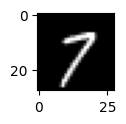

First Model's Reconstruction Image


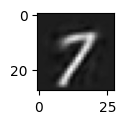

Second Model's Reconstruction Image


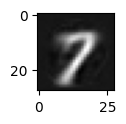

In [40]:
visualize_og_and_recon(model1 = Deep_model, model2 = shallow_model, test_x = test_x.to(device))

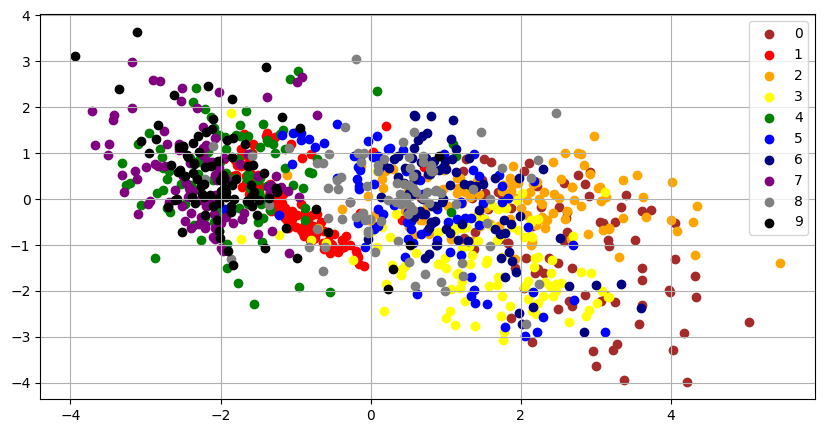

In [41]:
# Shallow AutoEncoder의 Latent Space 시각화

color_map = [
    'brown', 'red', 'orange', 'yellow', 'green',
    'blue', 'navy', 'purple', 'gray', 'black',
]  # 10개의 색을 이용: 0~9를 각각 brown, red, ..., black으로 시각화하기 위해.

plt.figure(figsize=(10, 5))

with torch.no_grad(): # 학습시키는 과정이 아니니까 with torch.no_gard(): 사용!
    latents = shallow_model.cpu().encoder(test_x[:1000].cpu())  # 1000개의 test data를 넣어봄
                                            # |latents| = (1000, 2)
    
    for i in range(10):
        target_latents = latents[test_y[:1000] == i].cpu()
        target_y = test_y[:1000][test_y[:1000] == i].cpu()
        plt.scatter(target_latents[:, 0],
                    target_latents[:, 1],
                    marker='o',
                    color=color_map[i],
                    label=i)
    
    plt.legend()
    plt.grid(axis='both')
    plt.show()

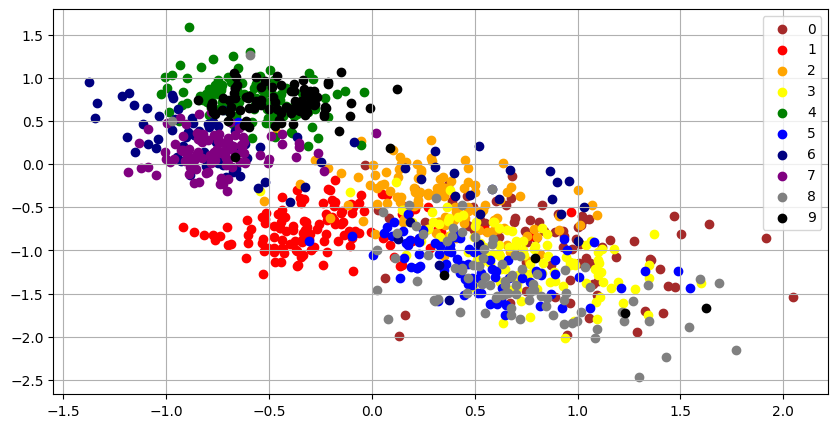

In [42]:
# Deep AutoEncoder의 Latent Space 시각화

color_map = [
    'brown', 'red', 'orange', 'yellow', 'green',
    'blue', 'navy', 'purple', 'gray', 'black',
]  

plt.figure(figsize=(10, 5))

with torch.no_grad(): 
    latents = Deep_model.cpu().encoder(test_x[:1000].cpu()) 
                                            
    
    for i in range(10):
        target_latents = latents[test_y[:1000] == i].cpu()
        target_y = test_y[:1000][test_y[:1000] == i].cpu()
        plt.scatter(target_latents[:, 0],
                    target_latents[:, 1],
                    marker='o',
                    color=color_map[i],
                    label=i)
    
    plt.legend()
    plt.grid(axis='both')
    plt.show()

## Bottleneck Size 변경하면서 모델 훈련 및 성능(MSE Loss) 평가

In [13]:
# Bottleneck Size = [ 2,  4,  6,  8, 10, 12, 14, 16, 18]으로 늘려가면서 모델 훈련시켜보기
model_list = []
Btl_size_list = np.arange(2,20,2) # 실험할 Bottleneck Size를 List 형태로 저장

for i in Btl_size_list: 
    globals()['model_btl_size{}'.format(i)] = Deep_AE(btl_size = i)
    model_list.append(globals()['model_btl_size{}'.format(i)]) # model_list에는 [model_1, model_2, model_3, ...]와 같이 AutoEncoder 모델들이 Element로 들어가 있음

# 각 모델을 불러와서 Train 수행
models = []
for model in model_list:   
    print('Model Training 시작')
    model = model
    optimizer = optim.Adam(model.parameters())
    crit = nn.MSELoss()
    trainer = Trainer(model, optimizer, crit, batch_size = 512, n_epochs = 100, verbose = 1)
    trainer.train((train_x.to(device), train_x.to(device)), (valid_x.to(device), valid_x.to(device)))
    models.append(model) # 수립된 모델은 models라는 새로운 List에 추가

Model Training 시작
Epoch(1/100): train_loss=9.1502e-02  valid_loss=5.0957e-02  lowest_loss=5.0957e-02
Epoch(21/100): train_loss=3.7423e-02  valid_loss=3.7176e-02  lowest_loss=3.7021e-02
Epoch(41/100): train_loss=3.5945e-02  valid_loss=3.5602e-02  lowest_loss=3.5562e-02
Epoch(61/100): train_loss=3.5153e-02  valid_loss=3.4782e-02  lowest_loss=3.4747e-02
Epoch(81/100): train_loss=3.4888e-02  valid_loss=3.4619e-02  lowest_loss=3.4256e-02
Model Training 시작
Epoch(1/100): train_loss=9.1522e-02  valid_loss=4.8587e-02  lowest_loss=4.8587e-02
Epoch(21/100): train_loss=2.8926e-02  valid_loss=2.8973e-02  lowest_loss=2.8973e-02
Epoch(41/100): train_loss=2.6645e-02  valid_loss=2.6899e-02  lowest_loss=2.6899e-02
Epoch(61/100): train_loss=2.5489e-02  valid_loss=2.5950e-02  lowest_loss=2.5950e-02
Epoch(81/100): train_loss=2.4622e-02  valid_loss=2.5475e-02  lowest_loss=2.5448e-02
Model Training 시작
Epoch(1/100): train_loss=9.2680e-02  valid_loss=4.8528e-02  lowest_loss=4.8528e-02
Epoch(21/100): train_loss

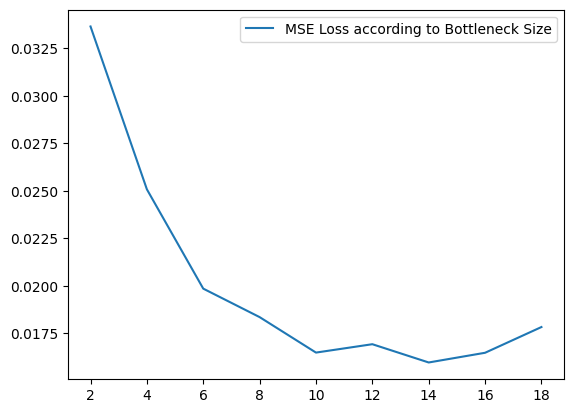

In [49]:
# Test Score 계산
crit = nn.MSELoss()
test_scores = [crit(models[i].cpu().forward(test_x).detach(), test_x.cpu()) for i in range(len(models))] # 수립된 각 Model의 Test Set에 대한 MSE Loss 측정
plt.plot(Btl_size_list,test_scores, label = "MSE Loss according to Bottleneck Size")
plt.legend()

Model Training 시작
Epoch(1/100): train_loss=8.9364e-02  valid_loss=4.6527e-02  lowest_loss=4.6527e-02
Epoch(21/100): train_loss=2.3079e-02  valid_loss=2.3235e-02  lowest_loss=2.3027e-02
Epoch(41/100): train_loss=2.0645e-02  valid_loss=2.0419e-02  lowest_loss=2.0419e-02
Epoch(61/100): train_loss=1.8606e-02  valid_loss=1.8951e-02  lowest_loss=1.8876e-02
Epoch(81/100): train_loss=1.7527e-02  valid_loss=1.7925e-02  lowest_loss=1.7912e-02
Model Training 시작
Epoch(1/100): train_loss=8.9095e-02  valid_loss=4.5997e-02  lowest_loss=4.5997e-02
Epoch(21/100): train_loss=2.3182e-02  valid_loss=2.2965e-02  lowest_loss=2.2965e-02
Epoch(41/100): train_loss=1.8626e-02  valid_loss=1.8666e-02  lowest_loss=1.8666e-02
Epoch(61/100): train_loss=1.6869e-02  valid_loss=1.7095e-02  lowest_loss=1.7095e-02
Epoch(81/100): train_loss=1.5901e-02  valid_loss=1.6209e-02  lowest_loss=1.6209e-02
Model Training 시작
Epoch(1/100): train_loss=9.0385e-02  valid_loss=4.6350e-02  lowest_loss=4.6350e-02
Epoch(21/100): train_loss

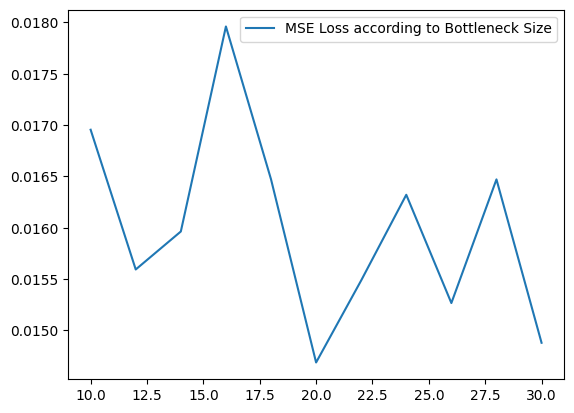

In [11]:
# 위 실험 결과 그래프 보니 Bottleneck Size가 18일 때부터 다시 상승하는 것으로 보여 Bottle_size_list를 추가해서 실험함
model_list_2 = []
Btl_size_list_2 = np.arange(10,30+1,2) # 실험할 Bottleneck Size = [10, 12, 14, 16, ..., 28, 30]
                                       # 실험 Bottleneck Size = [2, 4, 6, 8, ..., 28, 30]

for i in Btl_size_list_2: 
    globals()['model_btl_size{}'.format(i)] = Deep_AE(btl_size = i)
    model_list_2.append(globals()['model_btl_size{}'.format(i)]) 

models_2 = []
for model in model_list_2:   
    print('Model Training 시작')
    model = model
    optimizer = optim.Adam(model.parameters())
    crit = nn.MSELoss()
    trainer = Trainer(model, optimizer, crit, batch_size = 512, n_epochs = 100, verbose = 1)
    trainer.train((train_x.to(device), train_x.to(device)), (valid_x.to(device), valid_x.to(device)))
    models_2.append(model) 

# Test Score 계산 및 시각화
crit = nn.MSELoss()
test_scores = [crit(models_2[i].cpu().forward(test_x).detach(), test_x.cpu()) for i in range(len(models_2))] 
plt.plot(Btl_size_list_2, test_scores, label = "MSE Loss according to Bottleneck Size")
plt.legend()

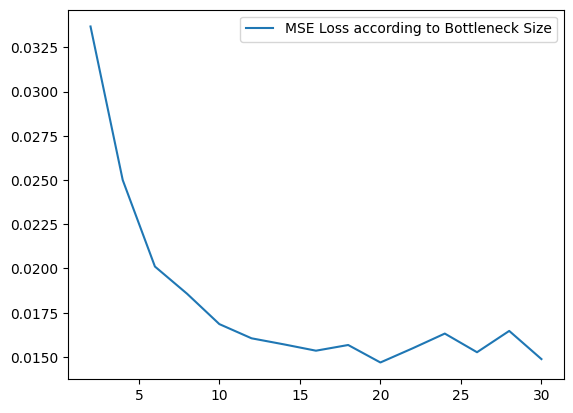

In [17]:
models_total = models + models_2[5:]
btl_total = Btl_size_list.tolist() + Btl_size_list_2[5:].tolist()

crit = nn.MSELoss()
test_scores = [crit(models_total[i].cpu().forward(test_x).detach(), test_x.cpu()) for i in range(len(models_total))] 
plt.plot(btl_total, test_scores, label = "MSE Loss according to Bottleneck Size")
plt.legend()

In [53]:
def show_latent_space(model, data: tuple):
    color_map = [
    'brown', 'red', 'orange', 'yellow', 'green',
    'blue', 'navy', 'purple', 'gray', 'black',
    ]

    test_x, test_y = data[0], data[1]

    plt.figure(figsize = (10,5))
    with torch.no_grad():
        latents = model.cpu().encoder(test_x[:1000].cpu())

        for i in range(10):
            target_latents = latents[test_y[:1000] == i].cpu()
            # target_y = test_y[:1000][test_y[:1000] == i].cpu()
            plt.scatter(target_latents[:, 0],
                      target_latents[:, 1],
                        marker='o',
                        color=color_map[i],
                        label=i)
    
        plt.legend()
        plt.grid(axis='both')
        plt.show()

==== Bottle Neck Size = 2일 때 Latent Space ====


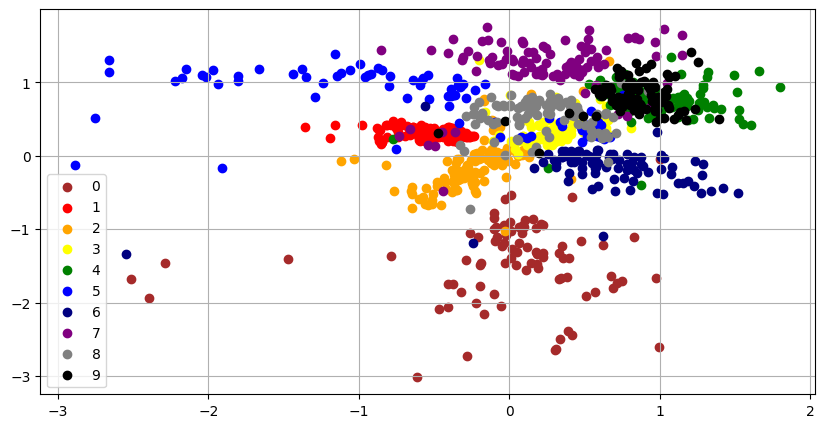

==== Bottle Neck Size = 4일 때 Latent Space ====


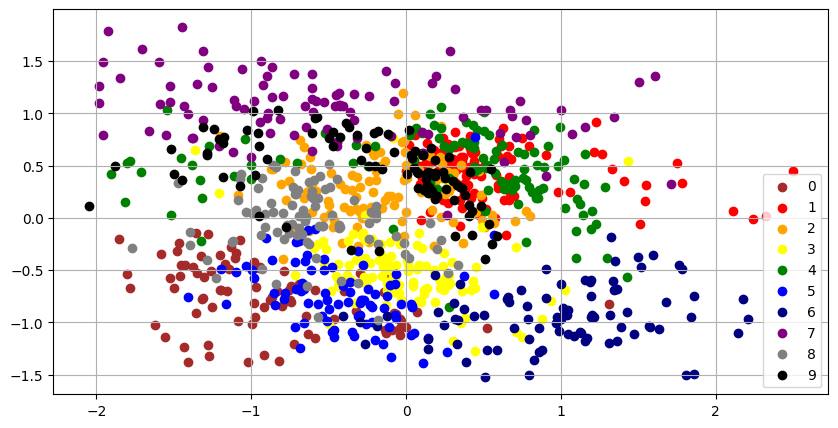

==== Bottle Neck Size = 6일 때 Latent Space ====


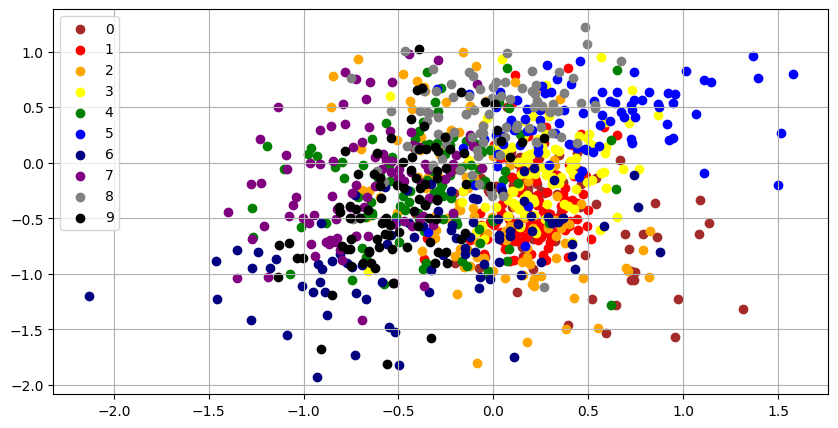

==== Bottle Neck Size = 8일 때 Latent Space ====


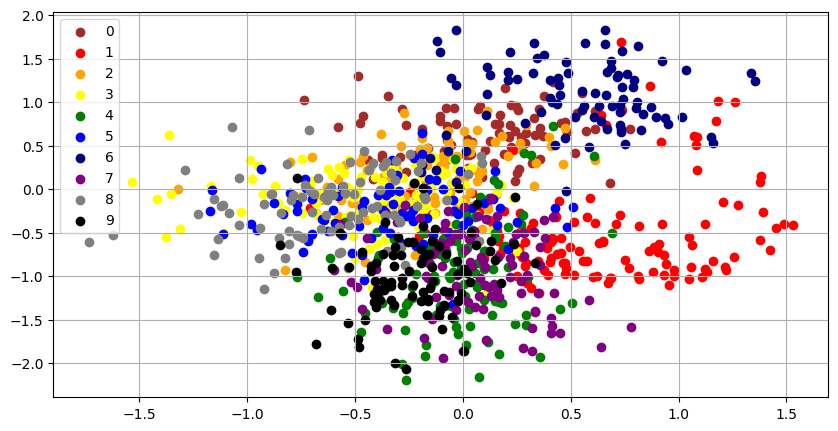

==== Bottle Neck Size = 10일 때 Latent Space ====


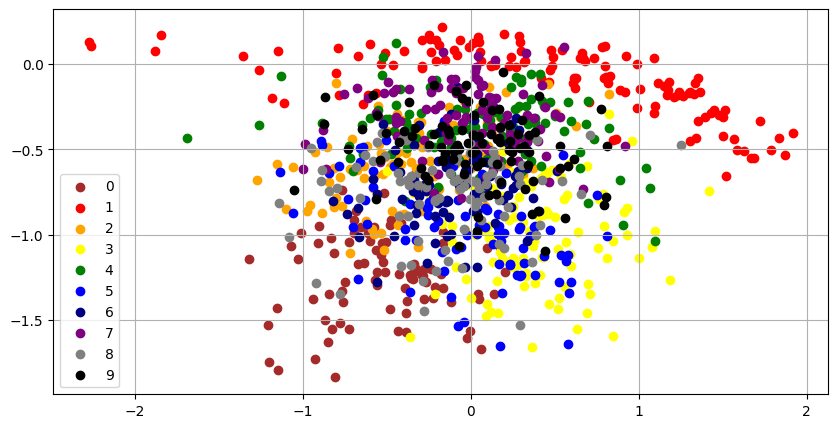

==== Bottle Neck Size = 12일 때 Latent Space ====


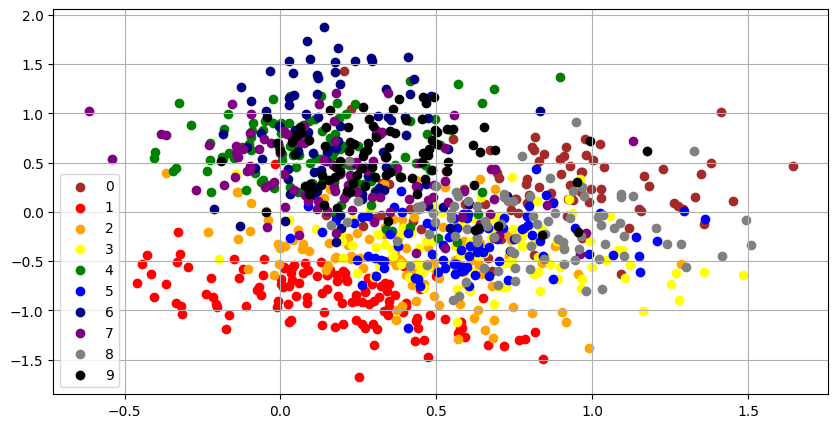

==== Bottle Neck Size = 14일 때 Latent Space ====


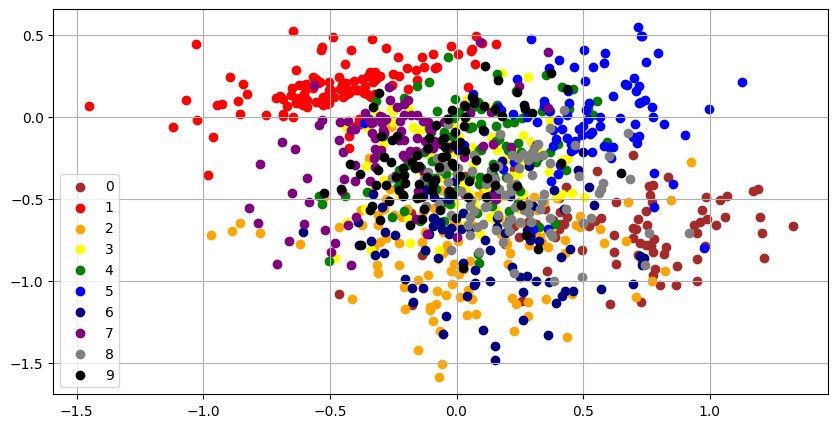

==== Bottle Neck Size = 16일 때 Latent Space ====


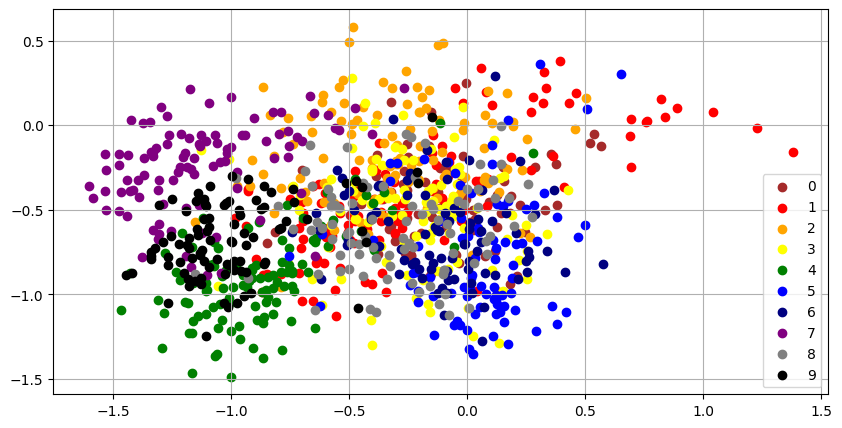

==== Bottle Neck Size = 18일 때 Latent Space ====


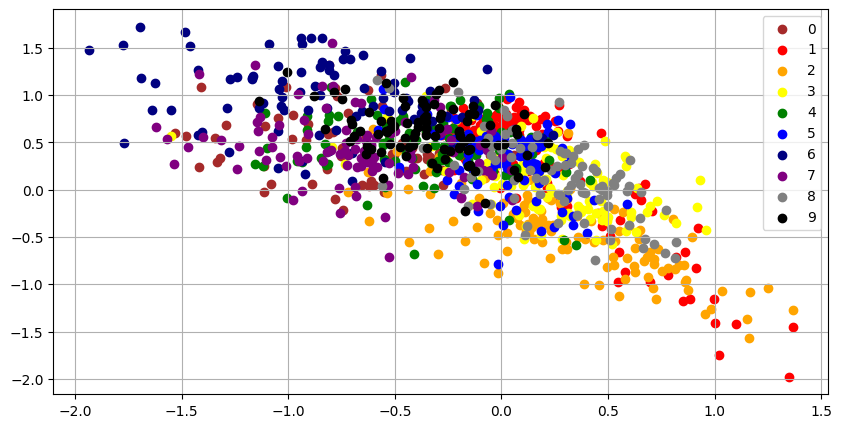

In [57]:
for i in range(len(models)):
    print(f"==== Bottle Neck Size = {Btl_size_list[i]}일 때 Latent Space ====")
    show_latent_space(models[i], (test_x, test_y))

In [58]:
# 원본 이미지와 복원된 이미지 시각화 코드
def visualize_og_and_recon(model1, test_x):
    with torch.no_grad():
        index = int(random.random() * test_x.size(0)) # |test_x| = (10000, 784)  # test_x.size(0) = 10000
        recon_1 = model1(test_x[index].view(1,-1)).squeeze() # |test_x[index]| = (784,)
        
        print('Original Image')
        show_image(test_x[index])
        print('='*40)
        print(f'Model\'s Reconstruction Image')
        show_image(recon_1)

Original Image


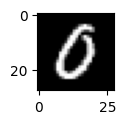

Model's Reconstruction Image


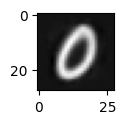

In [59]:
# Bottleneck Size가 가장 작은 (btl_size = 2) 모델의 이미지 복원 결과 시각화
visualize_og_and_recon(models[0], test_x)

Original Image


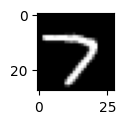

Model's Reconstruction Image


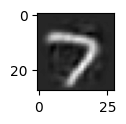

In [126]:
# Bottleneck Size 가 10인 모델의 이미지 복원 결과 시각화
visualize_og_and_recon(models[4], test_x)

Original Image


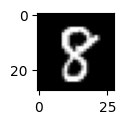

Model's Reconstruction Image


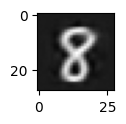

In [60]:
# Bottleneck Size가 가장 큰 (btl_size = 18) 모델의 이미지 복원 결과 시각화
visualize_og_and_recon(models[-1], test_x)

# AutoEncoder for Anomaly Detection
- 기존 AutoEncoder에서 Loss function을 MSE Loss로 사용했음
- MSE Loss 값을 Reconstruction Error로 사용
- 한 Instance의 Reconstruction Error 값이 특정 Threshold보다 높으면 Anomaly로 판단

In [22]:
# 인위적으로 Anomaly Instance 생성
# 본 튜토리얼에서 AutoEncoder는 숫자 0~9만을 이용해서 학습을 진행했음
# 따라서 숫자가 아닌 알파벳이나 한글 이미지가 입력되면 Reconstruction Error가 정상(숫자) 데이터에 비해 높아 Anomaly로 판단할 것임

from PIL import Image, ImageDraw, ImageFont

def make_anomaly_image(text: str):
    # 이미지로 출력할 글자 및 폰트 지정
    draw_text = text
    font = ImageFont.truetype('/root/BA/NanumSquareB.ttf')

    # 이미지 사이즈 지정 (MNIST Dataset의 이미지 크기와 동일하게 지정)
    text_width, text_height = 28, 28

    # 이미지 객체 생성 (MNIST 셋과 동일하게 이미지 Channel은 Grayscale, 배경은 검은색으로)
    canvas = Image.new('L', (text_width, text_height), "black")

    # 가운데에 그리기
    draw = ImageDraw.Draw(canvas)
    w, h = font.getsize(draw_text)
    draw.text(((text_width-w)/2.0,(text_height-h)/2.0), draw_text, 'white', font)
    display(canvas)  # 만들어진 텍스트 이미지 보기

    # Tensor 형태로 변환
    canvas = torch.Tensor(np.array(canvas)/ 255.) + 0.2*np.random.normal(0,1, size = (28,28)) # 가우시안 노이즈 추가
    return canvas

In [23]:
# 인위적으로 anomaly image 80장을 만들고 원래 test_x에서 920장 가져와서 model 별 성능 측정하기  --> 생각해보니 이것들은 label이 없어서 성능 측정이 불가능하네??? text_x[:920]에 대한 label은 test_y[:920]
korean = "가,나,다,라,마,바,사,아,자,차,카,타,파,하".split(",")
english = "A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z".split(",")

artificial_anomalies = [make_anomaly_image(x).flatten() for x in (korean + english)]
noised_anomalies = [image + 0.1*np.random.uniform(0,1,size = image.shape) for image in artificial_anomalies]
artificial_anomalies += noised_anomalies

artificial_anomalies = torch.stack(artificial_anomalies, dim = 0)

# 기존 test_x 에서 Normal 데이터 920개, 새롭게 생성한 이상치 데이터 80개를 합쳐서 새로운 test_x 데이터와 해당하는 Label을 가진 test_y 생성
new_test_x = torch.cat([test_x[:920,].cpu(), artificial_anomalies], dim = 0)
new_test_y = [0]*920 + [1]*80

print(new_test_x.shape)
print(len(new_test_y))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.


torch.Size([1000, 784])
1000


In [19]:
# Train Data를 이용해서 각 모델별 Threshold 구하기

def find_threshold(models:list, train_x) -> dict:
    model_threshold_dict = {}
    for i in range(len(models)):
        model = models[i].cpu()
        train_x = train_x.cpu()
        output = models[i].forward(train_x).detach()
        losses = torch.mean(((train_x - output)**2), dim = -1)
        model_threshold_dict[i] = np.round(np.percentile(losses, 90), 4) 

    return model_threshold_dict

In [164]:
model_threshold_dict = find_threshold(models, train_x)
model_threshold_dict

{0: 0.0528,
 1: 0.0384,
 2: 0.0303,
 3: 0.0276,
 4: 0.0249,
 5: 0.0254,
 6: 0.024,
 7: 0.0248,
 8: 0.027}

In [20]:
def anomaly_detect(x, model, threshold = 0.06):
    if x.dim() == 1:
        x = x.unsqueeze(dim=0)

    model_outputs = model.forward(x).detach()
    actuals = x
    preds = []
    recon_errors = []

    crit = nn.MSELoss()
    
    for model_output, actual in zip(model_outputs, actuals):
        recon_errors.append(crit(model_output,actual))

    preds = [1 if recon_error > threshold else 0 for recon_error in recon_errors ] # Reconstruction Error가 Threshold보다 크면 1(Anomaly), Threshold보다 작으면 0(Normal)으로 판단
    
    return preds

In [176]:
preds = []

for i, model in enumerate(models):
    model_threshold = model_threshold_dict[i] # 모델별로 상이한 threshold를 적용함
    preds.append(anomaly_detect(x = new_test_x.type(torch.float32), model = model, threshold = model_threshold)) # preds[0]: 첫번째 model의 예측 결과, preds[1]: 두번째 model의 에측 결과, ...

In [25]:
# Accuracy 및 F1 Score 반환하는 함수 정의
from sklearn.metrics import accuracy_score, f1_score

def result_metrics(pred, actual):
    assert len(pred) == len(actual)
    f1 = f1_score(actual, pred)
    accuracy = accuracy_score(actual, pred)
    return f1, accuracy

In [178]:
for i, i_th_model_pred in enumerate(preds):
    f1, accuracy = result_metrics(i_th_model_pred,new_test_y)
    print(f'{i} 번째 Model의 성능: Accuracy = {accuracy}, F1-Score = {f1:.4f}') 

0 번째 Model의 성능: Accuracy = 0.896, F1-Score = 0.6061
1 번째 Model의 성능: Accuracy = 0.863, F1-Score = 0.5387
2 번째 Model의 성능: Accuracy = 0.854, F1-Score = 0.5229
3 번째 Model의 성능: Accuracy = 0.854, F1-Score = 0.5229
4 번째 Model의 성능: Accuracy = 0.846, F1-Score = 0.5096
5 번째 Model의 성능: Accuracy = 0.853, F1-Score = 0.5212
6 번째 Model의 성능: Accuracy = 0.86, F1-Score = 0.5333
7 번째 Model의 성능: Accuracy = 0.86, F1-Score = 0.5333
8 번째 Model의 성능: Accuracy = 0.85, F1-Score = 0.5161


In [26]:
# Bottleneck_size List 추가한 것에 대한 Anomaly Detection 성능 실험
model_threshold_dict_2 = find_threshold(models_2[5:], train_x) # Btl_size = 20, 22, 24, 26, 28, 30에 대해서 측정

preds = []

for i, model in enumerate(models_2[5:]):
    model_threshold = model_threshold_dict_2[i] 
    preds.append(anomaly_detect(x = new_test_x.type(torch.float32), model = model, threshold = model_threshold))

for i, i_th_model_pred in enumerate(preds):
    f1, accuracy = result_metrics(i_th_model_pred,new_test_y)
    print(f'{i} 번째 Model의 성능: Accuracy = {accuracy}, F1-Score = {f1:.4f}') 

0 번째 Model의 성능: Accuracy = 0.847, F1-Score = 0.5112
1 번째 Model의 성능: Accuracy = 0.857, F1-Score = 0.5281
2 번째 Model의 성능: Accuracy = 0.851, F1-Score = 0.5178
3 번째 Model의 성능: Accuracy = 0.84, F1-Score = 0.5000
4 번째 Model의 성능: Accuracy = 0.852, F1-Score = 0.5195
5 번째 Model의 성능: Accuracy = 0.853, F1-Score = 0.5212


## Encoder Layer, Decoder Layer 비대칭 실험

In [93]:
# 아래 코드에서 Enc_Deeper_AE, Dec_Deeper_AE는 각각 약 13만 개의 파라미터 사용, 9개의 Layer 사용 
# 아래 비교 대상 Baseline_AE도 이와 유사한 환경을 맞춰주기 위해 파라미터 수(약 12만 5천개) 및 Layer 수 (총 8개의 Layer) 설정함
class Baseline_AE(nn.Module):
    
    def __init__(self, btl_size=2):   
        self.btl_size = btl_size
        
        super().__init__()
        
        # Encoder에는 6개의 Layer를, Decoder에는 3개의 Layer를 사용하여 테스트
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28,75),  
            nn.ReLU(),
            nn.Linear(75, 45),
            nn.ReLU(),
            nn.Linear(45, btl_size),    
        )
        self.decoder = nn.Sequential(
            nn.Linear(btl_size, 45),
            nn.ReLU(),
            nn.Linear(45,75),
            nn.ReLU(),
            nn.Linear(75, 28 * 28),
        )        
        
    def forward(self, x):
        z = self.encoder(x)  # |x| = (batch_size, 784), |z| = (batch_size, btl_size)
        y = self.decoder(z)  # |y| = |x|
        
        return y

In [94]:
# Baseline AutoEncoder Train
Baseline_model = Baseline_AE(btl_size=5)
Baseline_model = Baseline_model
optimizer = optim.Adam(Baseline_model.parameters())
crit = nn.MSELoss()

trainer = Trainer(Baseline_model, optimizer, crit, batch_size = 512, n_epochs = 100, verbose = 1)
trainer.train((train_x.to(device), train_x.to(device)), (valid_x.to(device),valid_x.to(device)))

Epoch(1/100): train_loss=7.1084e-02  valid_loss=5.6415e-02  lowest_loss=5.6415e-02
Epoch(21/100): train_loss=3.1210e-02  valid_loss=3.1300e-02  lowest_loss=3.1300e-02
Epoch(41/100): train_loss=2.9477e-02  valid_loss=2.9722e-02  lowest_loss=2.9722e-02
Epoch(61/100): train_loss=2.8713e-02  valid_loss=2.9057e-02  lowest_loss=2.9056e-02
Epoch(81/100): train_loss=2.8240e-02  valid_loss=2.8681e-02  lowest_loss=2.8679e-02


In [169]:
# 위에서 정의했던 find_threshold()함수에는 models라는 list로 인풋을 넣었는데 현재 상황에서는 개별 모델을 넣기 때문에 수정함
def single_model_find_threshold(model, train_x):
    model = model.cpu()
    train_x = train_x.cpu()
    output = model.forward(train_x).detach()
    losses = torch.mean(((train_x - output)**2), dim = -1)
    model_threshold = np.round(np.percentile(losses, 90), 4)

    return model_threshold

In [179]:
model_threshold = single_model_find_threshold(Baseline_model, train_x)
print(f'Anomaly Threshold: {model_threshold}')

preds = anomaly_detect(x = new_test_x.type(torch.float32), model = model, threshold = model_threshold)

Anomaly Threshold: 0.0453


In [180]:
f1, accuracy = result_metrics(preds,new_test_y)
print(f'Accuracy = {accuracy}, F1-Score = {f1:.4f}') # 5번째 Model: Btl_size = 14가 가장 높은 성능

Accuracy = 0.977, F1-Score = 0.8743


### Encoder Layer를 더 깊게 했을 때 예상 결과
- Encoder의 중요 역할은 Input Data의 중요한 정보를 압축하는 역할인데, Decoder에 비해 Encoder의 깊이가 깊다보니 Decoder가 충분히 복원해내지 못할만큼 압축이 되어서 성능 저하로 이어질 것으로 예상

In [98]:
class Enc_Deeper_AE(nn.Module):
    
    def __init__(self, btl_size=2):   
        self.btl_size = btl_size
        
        super().__init__()
        
        # Encoder에는 6개의 Layer를, Decoder에는 3개의 Layer를 사용하여 테스트
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 100),  
            nn.ReLU(),
            nn.Linear(100, 70),
            nn.ReLU(),
            nn.Linear(70,50),
            nn.ReLU(),
            nn.Linear(50,30),
            nn.ReLU(),
            nn.Linear(30, btl_size),    
        )
        self.decoder = nn.Sequential(
            nn.Linear(btl_size, 50),
            nn.ReLU(),
            nn.Linear(50, 28 * 28),
        )        
        
    def forward(self, x):
        z = self.encoder(x)  # |x| = (batch_size, 784), |z| = (batch_size, btl_size)
        y = self.decoder(z)  # |y| = |x|
        
        return y

In [99]:
# Encoder Deeper - AutoEncoder Train
Enc_Deeper_model = Enc_Deeper_AE(btl_size=5)
Enc_Deeper_model = Enc_Deeper_model.to(device)
optimizer = optim.Adam(Enc_Deeper_model.parameters())
crit = nn.MSELoss()

trainer = Trainer(Enc_Deeper_model, optimizer, crit, batch_size = 512, n_epochs = 100, verbose = 1)
trainer.train((train_x.to(device), train_x.to(device)), (valid_x.to(device),valid_x.to(device)))

Epoch(1/100): train_loss=7.8638e-02  valid_loss=6.1319e-02  lowest_loss=6.1319e-02
Epoch(21/100): train_loss=3.3427e-02  valid_loss=3.3417e-02  lowest_loss=3.3417e-02
Epoch(41/100): train_loss=3.1858e-02  valid_loss=3.1940e-02  lowest_loss=3.1940e-02
Epoch(61/100): train_loss=3.1168e-02  valid_loss=3.1373e-02  lowest_loss=3.1364e-02
Epoch(81/100): train_loss=3.0769e-02  valid_loss=3.1079e-02  lowest_loss=3.1041e-02


In [182]:
model_threshold = single_model_find_threshold(Enc_Deeper_model, train_x)
print(f'Anomaly Threshold: {model_threshold}')

preds = anomaly_detect(x = new_test_x.type(torch.float32), model = model, threshold = model_threshold)

Anomaly Threshold: 0.048


In [183]:
f1, accuracy = result_metrics(preds,new_test_y)
print(f'Accuracy = {accuracy}, F1-Score = {f1:.4f}') # 5번째 Model: Btl_size = 14가 가장 높은 성능

Accuracy = 0.98, F1-Score = 0.8876


### Decoder Layer를 더 깊게 했을 때 예상 결과
- Decoder의 역할은 Encoder를 통해 압축된 Input Data를 통해 원본 데이터를 복원하는 것인데, 이러한 측면에서 예상하기로는 Decoder의 깊이가 깊어진 것은 성능 저하로 이어지지 않을 것으로 예상됨

In [110]:
class Dec_Deeper_AE(nn.Module):
    
    def __init__(self, btl_size=2):   
        self.btl_size = btl_size
        
        super().__init__()
        
        # Encoder에는 6개의 Layer를, Decoder에는 3개의 Layer를 사용하여 테스트
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 50),  
            nn.ReLU(),
            nn.Linear(50, btl_size),    
        )
        self.decoder = nn.Sequential(
            nn.Linear(btl_size, 30),
            nn.ReLU(),
            nn.Linear(30,50),
            nn.ReLU(),
            nn.Linear(50,70),
            nn.ReLU(),
            nn.Linear(70,100),
            nn.ReLU(),
            nn.Linear(100, 28 * 28),
        )        
        
    def forward(self, x):
        z = self.encoder(x)  # |x| = (batch_size, 784), |z| = (batch_size, btl_size)
        y = self.decoder(z)  # |y| = |x|
        
        return y

In [103]:
# Decoder Deeper - AutoEncoder Train
Dec_Deeper_model = Dec_Deeper_AE(btl_size=5)
Dec_Deeper_model = Dec_Deeper_model.to(device)
optimizer = optim.Adam(Dec_Deeper_model.parameters())
crit = nn.MSELoss()

trainer = Trainer(Dec_Deeper_model, optimizer, crit, batch_size = 512, n_epochs = 100, verbose = 1)
trainer.train((train_x.to(device), train_x.to(device)), (valid_x.to(device),valid_x.to(device)))

Epoch(1/100): train_loss=7.2000e-02  valid_loss=6.0933e-02  lowest_loss=6.0933e-02
Epoch(21/100): train_loss=3.1200e-02  valid_loss=3.1357e-02  lowest_loss=3.1357e-02
Epoch(41/100): train_loss=2.9509e-02  valid_loss=2.9734e-02  lowest_loss=2.9734e-02
Epoch(61/100): train_loss=2.8770e-02  valid_loss=2.9196e-02  lowest_loss=2.9126e-02
Epoch(81/100): train_loss=2.8263e-02  valid_loss=2.8674e-02  lowest_loss=2.8652e-02


In [184]:
model_threshold = single_model_find_threshold(Dec_Deeper_model, train_x)
print(f'Anomaly Threshold: {model_threshold}')

preds = anomaly_detect(x = new_test_x.type(torch.float32), model = model, threshold = model_threshold)

Anomaly Threshold: 0.0453


In [185]:
f1, accuracy = result_metrics(preds,new_test_y)
print(f'Accuracy = {accuracy}, F1-Score = {f1:.4f}') 

Accuracy = 0.977, F1-Score = 0.8743
